In [22]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
#https://pytorch.org/docs/stable/torchvision/index.html
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

### 数据读取与数据预处理

In [23]:
data_dir = './flower_data/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

- data_transforms 指定了所有图像预处理操作

In [24]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(224),#从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [25]:
batch_size = 8

# 数据集：{train: ..., valid: ...}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
# 数据集的数据个数：{train: ..., valid: ...}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
# 各个分类的名字（数据文件中以1、2、3、...、102来给花的种类命名）
class_names = image_datasets['train'].classes

In [26]:
# 数据集
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ./flower_data/train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ./flower_data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456,

- 读取标签对应的实际名字

In [27]:
# cat_to_name 文件存放了花的类别的实际名称
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

### 展示数据

- 注意tensor的数据需要转换成numpy的格式，而且还需要还原回标准化的结果

In [28]:
def im_convert(tensor):
    """ 展示数据"""
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    # [channel, h ,w] => [h, w, channel] 实际照片一般通道是在最后面的
    image = image.transpose(1,2,0)
    # 还原之前的 normalization 操作
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

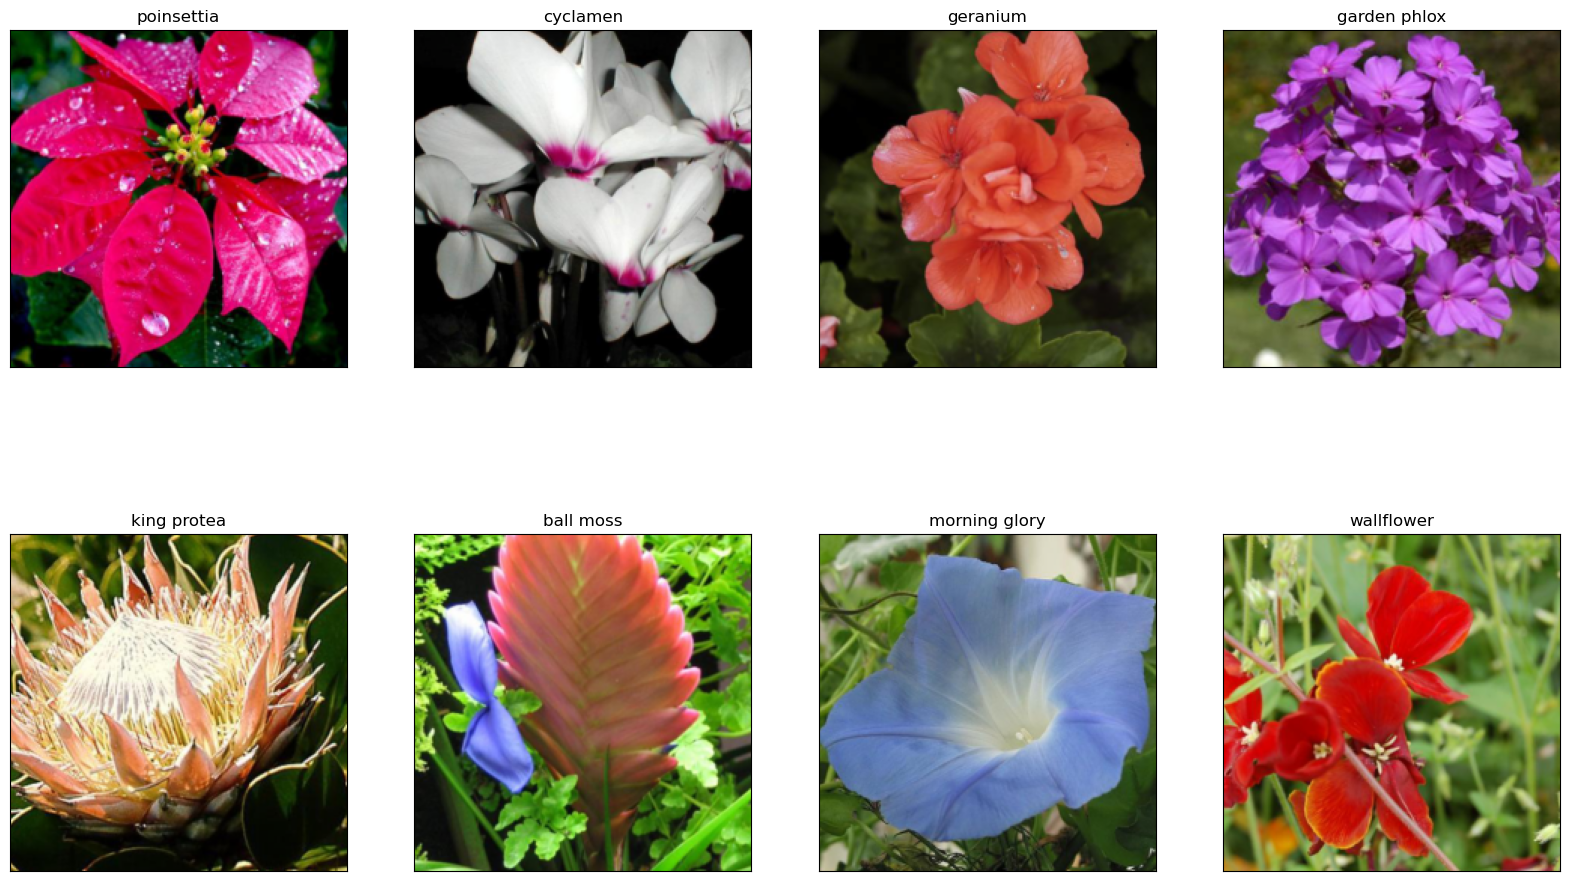

In [29]:
fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(dataloaders['valid'])
inputs, classes = next(dataiter)   # dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(cat_to_name[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

### 加载 pytorch 提供的模型

可以直接用别人已经训练好的权重参数当作初始化参数

In [30]:
# 是否用GPU训练
if not torch.cuda.is_available():
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [31]:
# 查看 torchvision.models 模块提供的 ResNet152 模型的网络结构
model_ft = models.resnet152()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### 参考 pytorch 官网的例子

In [32]:
# 设置模型参数的 requires_grad 属性
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # 把模型的所有层的参数的 requires_grad 属性设置为 false，表示不再对原本的参数进行训练
            param.requires_grad = False

In [33]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 选择合适的模型，不同模型的初始化方法稍微有点区别
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        # pretrained 参数表示是否需要用预训练模型的参数来初始化
        # pretrained=True 返回在 ImageNet 数据集上训练好的模型
        model_ft = models.resnet152(pretrained=use_pretrained)
        # 是否冻结所有层，不进行训练
        set_parameter_requires_grad(model_ft, feature_extract)
        # 获取全连接层的输入数据个数
        num_ftrs = model_ft.fc.in_features
        # 重新设置全连接层，新设置的层的参数的 requires_grad 默认都是 True，所以整个模型就只有新设置的全连接层需要训练（更新梯度）
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes),
                                   nn.LogSoftmax(dim=1))
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [34]:
# 可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
model_name = 'resnet'  
#是否用人家训练好的特征来做
feature_extract = True 

model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

a:\WorkApps\anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
a:\WorkApps\anaconda3\envs\deeplearning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


查看模型哪些层需要训练

In [35]:
# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


查看模型

In [36]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 优化器设置

In [37]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
# 学习率每7个epoch衰减成原来的1/10
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# 最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了
# nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
criterion = nn.NLLLoss()

### 训练模块

In [39]:
# 模型保存
filename='checkpoint.pth'

In [40]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, filename=filename):
    since = time.time()
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    # 取出概率最大的
                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),     # 模型的所有参数
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

### 开始训练

In [41]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20, is_inception=(model_name=="inception"))

Epoch 0/19
----------
Time elapsed 2m 4s
train Loss: 10.2511 Acc: 0.3078
Time elapsed 2m 17s
valid Loss: 12.3693 Acc: 0.3643


a:\WorkApps\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Optimizer learning rate : 0.0010000

Epoch 1/19
----------
Time elapsed 5m 2s
train Loss: 2.3726 Acc: 0.6973
Time elapsed 5m 17s
valid Loss: 3.5859 Acc: 0.6186
Optimizer learning rate : 0.0100000

Epoch 2/19
----------
Time elapsed 8m 2s
train Loss: 10.0202 Acc: 0.4753
Time elapsed 8m 18s
valid Loss: 13.6119 Acc: 0.4682
Optimizer learning rate : 0.0010000

Epoch 3/19
----------
Time elapsed 11m 12s
train Loss: 2.9507 Acc: 0.7363
Time elapsed 11m 30s
valid Loss: 4.0467 Acc: 0.6834
Optimizer learning rate : 0.0100000

Epoch 4/19
----------
Time elapsed 14m 12s
train Loss: 8.9538 Acc: 0.5517
Time elapsed 14m 27s
valid Loss: 14.1243 Acc: 0.4511
Optimizer learning rate : 0.0001000

Epoch 5/19
----------
Time elapsed 17m 9s
train Loss: 4.9816 Acc: 0.6857
Time elapsed 17m 25s
valid Loss: 7.4604 Acc: 0.6222
Optimizer learning rate : 0.0010000

Epoch 6/19
----------
Time elapsed 19m 60s
train Loss: 2.6780 Acc: 0.7776
Time elapsed 20m 13s
valid Loss: 5.3288 Acc: 0.6760
Optimizer learning rate : 

### 再继续训练所有层

In [42]:
# 把模型的所有层的参数的 requires_grad 属性设置为 True，相当于解冻所有层
for param in model_ft.parameters():
    param.requires_grad = True
    
# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(params_to_update, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.NLLLoss()

In [44]:
# 在之前训练好的基础之上再训练
# Load the checkpoint
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
# 加载权重参数
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
# model_ft.class_to_idx = checkpoint['mapping']

In [45]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=10, is_inception=(model_name=="inception"))

Epoch 0/9
----------
Time elapsed 5m 40s
train Loss: 2.6413 Acc: 0.8208
Time elapsed 5m 56s
valid Loss: 6.0577 Acc: 0.7359


a:\WorkApps\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Optimizer learning rate : 0.0010000

Epoch 1/9
----------
Time elapsed 11m 30s
train Loss: 2.5188 Acc: 0.8286
Time elapsed 11m 46s
valid Loss: 5.6809 Acc: 0.7457
Optimizer learning rate : 0.0010000

Epoch 2/9
----------
Time elapsed 18m 23s
train Loss: 2.3576 Acc: 0.8249
Time elapsed 18m 44s
valid Loss: 6.4791 Acc: 0.7164
Optimizer learning rate : 0.0010000

Epoch 3/9
----------
Time elapsed 24m 31s
train Loss: 2.3553 Acc: 0.8219
Time elapsed 24m 50s
valid Loss: 6.5484 Acc: 0.7200
Optimizer learning rate : 0.0010000

Epoch 4/9
----------
Time elapsed 31m 34s
train Loss: 2.2988 Acc: 0.8330
Time elapsed 31m 54s
valid Loss: 6.9091 Acc: 0.7066
Optimizer learning rate : 0.0010000

Epoch 5/9
----------
Time elapsed 37m 55s
train Loss: 2.3390 Acc: 0.8330
Time elapsed 38m 11s
valid Loss: 5.9117 Acc: 0.7384
Optimizer learning rate : 0.0010000

Epoch 6/9
----------
Time elapsed 43m 19s
train Loss: 2.1864 Acc: 0.8327
Time elapsed 43m 35s
valid Loss: 5.8368 Acc: 0.7445
Optimizer learning rate : 0.

### 测试网络模型效果

输入一张测试图像，看看网络的返回结果：

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']```
```

1. 加载训练好的模型

In [60]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='checkpoint.pth'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

2. 测试数据预处理
- 测试数据处理方法需要跟训练时一直才可以 
- crop操作的目的是保证输入的大小是一致的
- 标准化操作也是必须的，用跟训练数据相同的mean和std,但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化
- 最后一点，PyTorch中颜色通道是第一个维度，跟很多工具包都不一样，需要转换

In [61]:
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    # Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0] > img.size[1]:        
        img.thumbnail((10000, 256))    
    else:        
        img.thumbnail((256, 10000))
    # Crop操作（裁剪）
    left_margin = (img.width-224)/2    
    bottom_margin = (img.height-224)/2    
    right_margin = left_margin + 224    
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,
                        top_margin))
    # 相同的预处理方法
    img = np.array(img)/255    
    mean = np.array([0.485, 0.456, 0.406]) #provided mean    
    std = np.array([0.229, 0.224, 0.225]) #provided std    
    img = (img - mean)/std

    # 注意颜色通道应该放在第一个位置
    img = img.transpose((2, 0, 1))

    return img


In [62]:
def imshow(image, ax=None, title=None):    
    """展示数据"""    
    if ax is None:        
        fig, ax = plt.subplots()       
    # 颜色通道还原    
    image = np.array(image).transpose((1, 2, 0))        
    # 预处理还原    
    mean = np.array([0.485, 0.456, 0.406])    
    std = np.array([0.229, 0.224, 0.225])    
    image = std * image + mean    
    image = np.clip(image, 0, 1)        
    
    ax.imshow(image)    
    ax.set_title(title)        
    
    return ax

<Axes: >

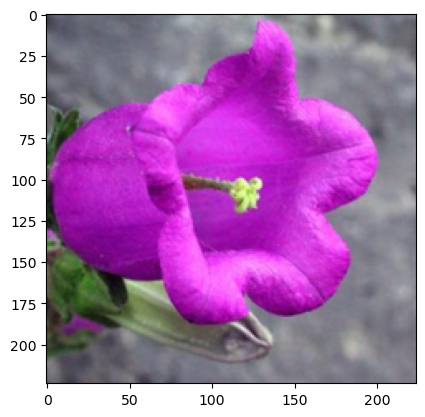

In [63]:
image_path = 'assets/image_06621.jpg'
img = process_image(image_path)
imshow(img)

In [64]:
img.shape

(3, 224, 224)

In [65]:
# 得到一个batch的测试数据
dataiter = iter(dataloaders['valid'])
images, labels = next(dataiter) # dataiter.next()

model_ft.eval()

if torch.cuda.is_available():    
    output = model_ft(images.cuda())
else:    
    output = model_ft(images)

output: [batch, num_classes]
<br/>
output表示对一个batch中每一个数据得到其属于各个类别的可能性

In [66]:
output.shape

torch.Size([8, 102])

得到概率最大的那个

In [67]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())
preds

array([68, 76, 49, 29, 80, 50, 98, 80], dtype=int64)

预测结果展示

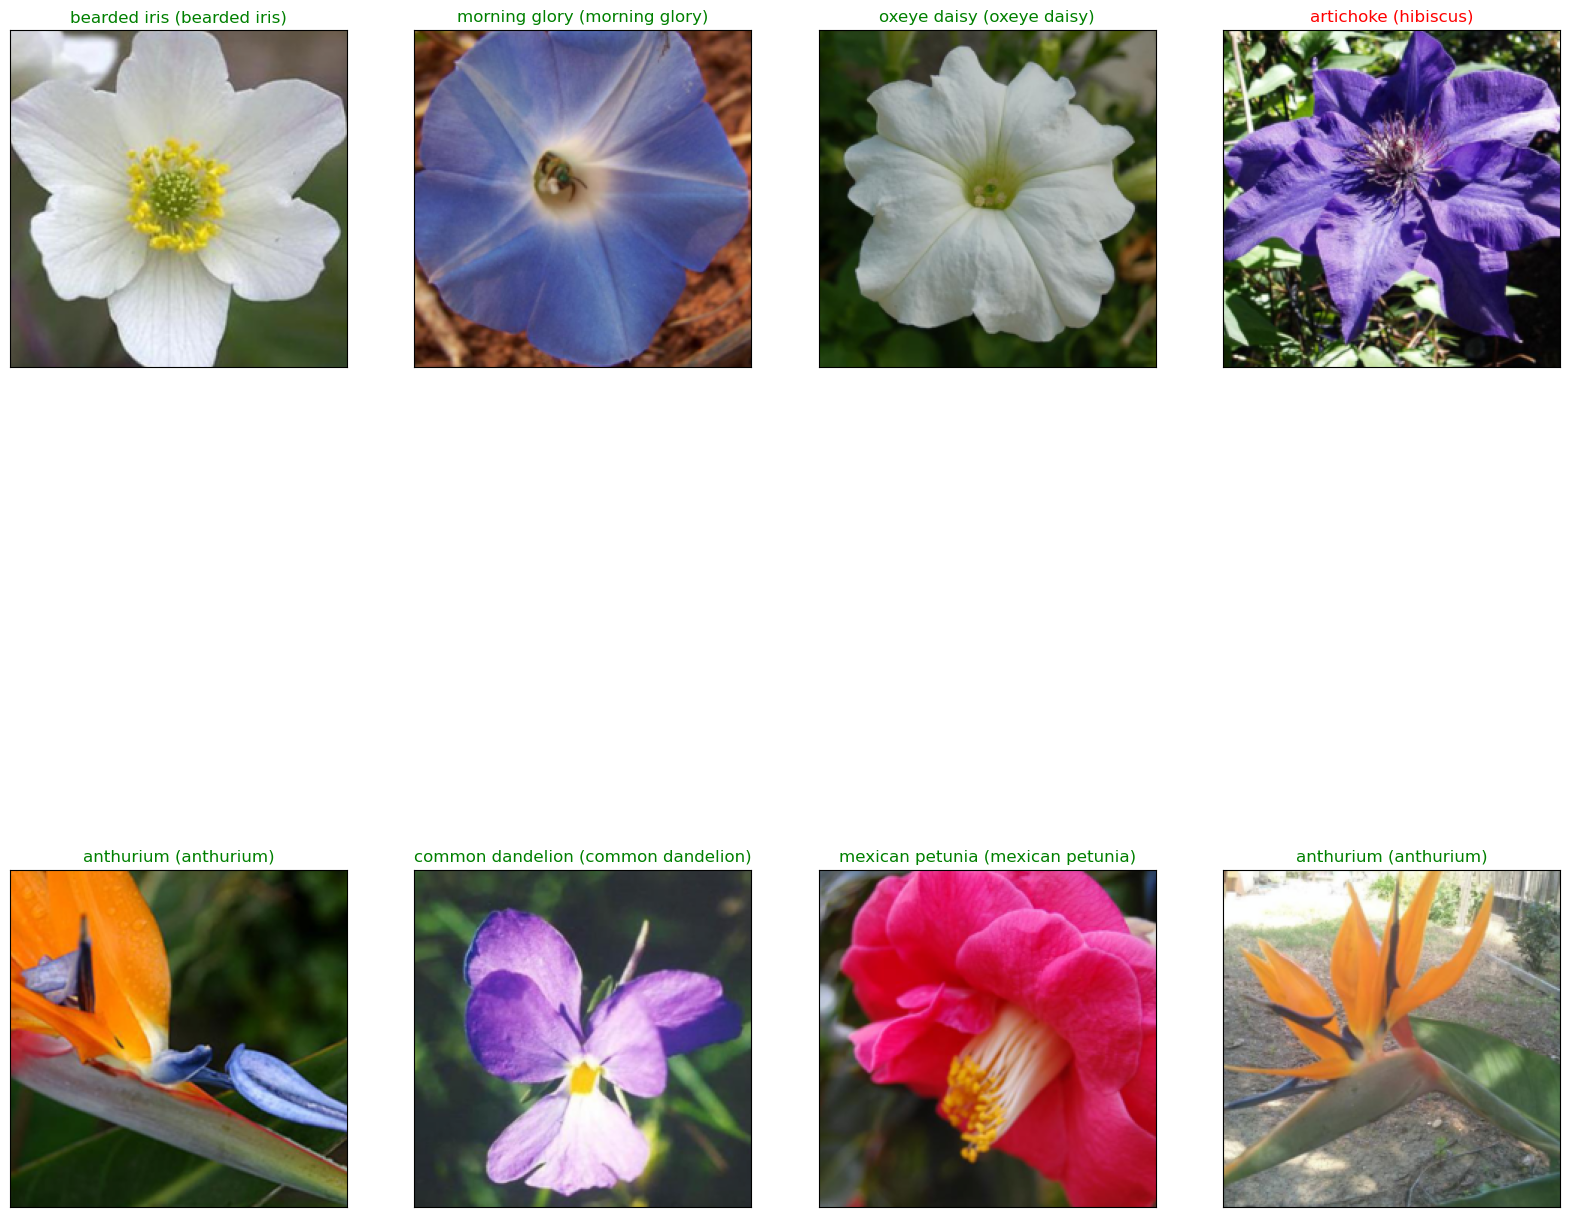

In [68]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2
for idx in range (columns*rows):    
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])    
    plt.imshow(im_convert(images[idx]))   
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),                 
                color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()